# Pipeline for High-z Radio Galaxies 12: Application of full pipeline for prediction

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd
import mpl_scatter_density
# import schemdraw
# from schemdraw import flow

In [2]:
mpl.rcdefaults()

Create path effects.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    try:
        med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    except:
        med = np.nanmedian(np.abs(z_true - z_pred))
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    try:
        med  = np.nanmedian(np.abs(frac)).astype('float32')
    except:
        med  = np.nanmedian(np.abs(frac))
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    try:
        rot = np.sqrt(ssq / len(z_true)).astype('float32')
    except:
        rot = np.sqrt(ssq / len(z_true))
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    try:
        rot = np.sqrt(ssq / len(z_true)).astype('float32')
    except:
        rot = np.sqrt(ssq / len(z_true))
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    try:
        siz  = np.sum(np.isfinite(dif)).astype('float32')
        num  = np.sum(np.array(dif > 0.15)).astype('float32')
    except:
        siz  = np.sum(np.isfinite(dif))
        num  = np.sum(np.array(dif > 0.15))
    frac = num / siz
    return frac

Methods for Pycaret and saved models.

In [9]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [10]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

Methods for the use of values in Confusion Matrices.

In [11]:
def flatten_CM(cm_array):
    try:
        TN, FP, FN, TP = cm_array.flatten().astype('float32')
    except:
        TN, FP, FN, TP = cm_array.flatten()
    return TN, FP, FN, TP

In [12]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = flatten_CM(cm_array)
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [13]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = flatten_CM(cm_array)
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [14]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = flatten_CM(cm_array)
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [15]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = flatten_CM(cm_array)
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [16]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(stretch=PowerStretch(0.35))

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal', values_format=',')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(28)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=16)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [17]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.5))

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

---

## Reading data

In [18]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Flags.

In [19]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False  # z >= 2.0
use_third_z_model   = False  # z >= 3.0
use_fourth_z_model  = True  # z >= 3.7 (with SMOGN), or, if needed, z >= 4.0
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [20]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'

In [21]:
if used_area != 'S82':
    compare_A17_flag = False

In [22]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_S82_Ananna_17  = f'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_Ananna_17_zsp_5sigma_imp.h5'  # 204 objects

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [23]:
# feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
# feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
# feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
#                      'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc_S82    = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [24]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [25]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [26]:
if use_zeroth_model:
    full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)

In [27]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [28]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

##### Random seed

In [29]:
seed                                = 42

---

Split dataset if from HETDEX

In [30]:
if used_area == 'HETDEX':
    full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)]
    train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2, random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
    # data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
    # data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data
    
    print('Shape of used data')
    print('-' * 40)
    print(f'Full Dataset size: {full_catalog_df.shape}')
    print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
    print(f'Unseen Data For Validation: {validation_df.shape}')
    print('-' * 40)
    full_catalog_df = validation_df

Shape of used data
----------------------------------------
Full Dataset size: (1760691, 58)
Data for Modeling (Train and Test): (1408552, 58)
Unseen Data For Validation: (352139, 58)
----------------------------------------


In [31]:
len(full_catalog_df.loc[:, "is_AGN"])

352139

In [32]:
np.shape(full_catalog_df)

(352139, 58)

In [33]:
np.sum(np.array(full_catalog_df.loc[:, 'is_AGN'] == 1))

6079

In [34]:
np.sum(np.array(full_catalog_df.loc[:, 'is_gal'] == 1))

346060

Discard minor features.

In [35]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])

---

### Load models

In [36]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model('models/classification_star_no_star_jun_30_2022')  # star/no-star model
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_16_2022')
    redshift_reg    = pyr.load_model('models/regression_z_may_17_2022')  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model('models/regression_z_may_18_2022')  # to use on sources with predicted z >= 2
    if use_third_z_model:
        redshift_reg_3  = pyr.load_model('models/regression_z_may_30_2022')  # to use on sources with predicted z >= 3
    if use_fourth_z_model:
        # redshift_reg_4  = pyr.load_model('models/regression_z_may_31_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        # redshift_reg_4  = pyr.load_model('models/regression_z_may_31_4_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)
        redshift_reg_4  = pyr.load_model('models/regression_z_jun_01_2022')  # to use on sources with predicted z >= 3.7 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [37]:
if use_zeroth_model:
    threshold_star = 0.37441  # 0.5, 0.15688 from ROC AUC in train+test, 0.37441 from PR curve
threshold_AGN   = 0.31117  # 0.5, 0.3094 from ROC AUC in train+test, 0.31117 from PR curve
threshold_radio = 4.99972232e-01  # 0.5, 4.99972232e-01 from ROC AUC in train+test and PR curve

In [38]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=threshold_star, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [39]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=7)

In [40]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=7)

In [41]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=10)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)

Scores before applying further z models

In [42]:
if use_zeroth_model:
    temp_filt_pred_nstr    = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN        = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio'] == 1) &\
                             temp_filt_pred_nstr
sigma_mad_early            = sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_nmad_early           = sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_early              = sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_norm_early         = sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
out_frac_early             = outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])

In [43]:
temp_z_limit               = 3.7
temp_filt_high_z_rAGN      = temp_filt_pred_rAGN * (full_catalog_df.loc[:, 'pred_Z'] >= temp_z_limit)
sigma_mad_early_hiz        = sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_nmad_early_hiz       = sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_early_hiz          = sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_norm_early_hiz     = sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
out_frac_early_hiz         = outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])

In [44]:
redshift_lim_a    = 2.0
redshift_tol_a    = 0.0
redshift_lim_b    = 3.0
redshift_tol_b    = 0.0
redshift_lim_c    = 3.7  # 3.7, 4.0
redshift_tol_c    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=10)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_a + redshift_tol_a)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)
if use_third_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_3, data=full_catalog_df, round=10)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_b + redshift_tol_b)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)
if use_fourth_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_4, data=full_catalog_df, round=10)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_c + redshift_tol_c)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=4)

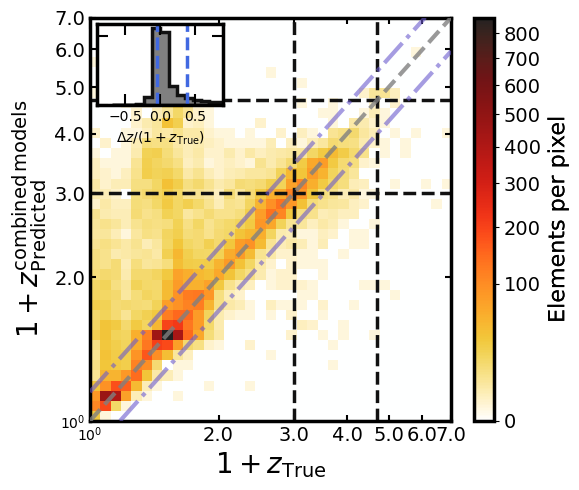

In [45]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axvline(x=(1 + redshift_lim_c), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_c), ls='--', c='k', lw=2.5)
if use_second_z_model or use_third_z_model or use_fourth_z_model:
    ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

In [46]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_no_star'] *\
                                        full_catalog_df.loc[:, 'Score_AGN'] *\
                                        full_catalog_df.loc[:, 'Score_radio']
rad_score_scaler                      = MinMaxScaler()
full_catalog_df['scaled_score_radio'] = rad_score_scaler.fit_transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [47]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
full_catalog_df.loc[:, displayed_cols].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,352139.000000,352139.00000,352139.000000,352139.000000,16427.000000,352139.000000
mean,0.017263,0.54535,0.075070,0.287225,0.810350,1.713118
std,0.130250,0.49794,0.263504,0.452468,0.724771,0.874100
min,0.000000,0.00000,0.000000,0.000000,-0.002180,0.040300
25%,0.000000,0.00000,0.000000,0.000000,0.328450,1.015250
50%,0.000000,1.00000,0.000000,0.000000,0.566620,1.859000
75%,0.000000,1.00000,0.000000,1.000000,1.078000,2.147900
max,1.000000,1.00000,1.000000,1.000000,5.830000,5.654800


##### Include AGN detection criteria from literature

In [48]:
full_catalog_df['M12_AGN'] = (np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 <
                                      0.315 * (full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 0.791) &
                              np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                                      0.315 * (full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 0.222) &
                              np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                                      -3.172 * (full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 7.624)).astype(int)

full_catalog_df['S12_AGN'] = np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >= 0.8).astype(int)

full_catalog_df['M16_AGN'] = (np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                              np.array(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 < 4.4)).astype(int)

full_catalog_df['B18_AGN'] = (np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                              np.array(full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 > 2.2) &
                              np.array(full_catalog_df.loc[:, 'W1mproPM'] - full_catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                                      2 * (full_catalog_df.loc[:, 'W2mproPM'] - full_catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 8.9)).astype(int)

Obtain intermediate metrics

In [49]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
filter_gal_AGN_t        = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_str_gal_AGN_t    = np.array(full_catalog_df.loc[:, 'class'] == 0) |\
                          np.array(full_catalog_df.loc[:, 'class'] == 1) |\
                          np.array(full_catalog_df.loc[:, 'class'] == 2)
total_size              = len(full_catalog_df)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 2))
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [50]:
# filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'Score_AGN']          >= threshold_AGN) &\
#                             np.array(full_catalog_df.loc[:, 'Score_radio']      >= threshold_radio)
if use_zeroth_model:
    filter_non_str_p      = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_p      = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_p        = full_catalog_df['pred_radio_AGN']
filt_hiz_rAGN_p           = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= redshift_lim_c)
filter_AGN_p              = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p
filter_radio_p            = np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_p           = filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)
num_AGN_p                 = np.sum(filter_AGN_p)
num_gal_p                 = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p)
num_radio_p               = np.sum(filter_radio_p)
num_radio_AGN_p           = np.sum(filter_radio_AGN_p)
num_rAGN_MQC_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_new_rAGN_p            = np.sum(filter_radio_AGN_p) - np.sum(filter_radio_AGN_t)

Confusion matrix for Star/not-star classification on confirmed sources (AGN + Galaxies + Stars)

In [51]:
if use_zeroth_model:
    cm_str = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 0) & np.array(full_catalog_df.loc[:, 'pred_star'] == 0)),\
                        np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 0) & np.array(full_catalog_df.loc[:, 'pred_star'] == 1))],\
                       [np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1) & np.array(full_catalog_df.loc[:, 'pred_star'] == 0)),\
                        np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1) & np.array(full_catalog_df.loc[:, 'pred_star'] == 1))]])

Confusion matrix for AGN prediction on confirmed sources (AGN/galaxies). Including initial prediction of not being star.

In [52]:
np.sum(filter_gal_AGN_t)

352139

In [53]:
np.shape(filter_gal_AGN_t)

(352139,)

In [54]:
np.unique(full_catalog_df.loc[filter_gal_AGN_t, 'class'], return_counts=True)

(array([0., 1.]), array([346060,   6079]))

In [55]:
np.unique(full_catalog_df.loc[filter_gal_AGN_t, 'pred_class'], return_counts=True)

(array([0, 1]), array([160100, 192039]))

In [56]:
tmp_filt_AGN = filter_non_str_p * filter_gal_AGN_t
cm_AGN = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_AGN, 'class'] == 0) & np.array(full_catalog_df.loc[tmp_filt_AGN, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[tmp_filt_AGN, 'class'] == 0) & np.array(full_catalog_df.loc[tmp_filt_AGN, 'pred_class'] == 1))],\
                   [np.sum(np.array(full_catalog_df.loc[tmp_filt_AGN, 'class'] == 1) & np.array(full_catalog_df.loc[tmp_filt_AGN, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[tmp_filt_AGN, 'class'] == 1) & np.array(full_catalog_df.loc[tmp_filt_AGN, 'pred_class'] == 1))]])

Confusion matrix for AGN prediction on all sources (AGN/galaxies + unknown [stars])

In [57]:
cm_AGN_large = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 0.5)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p)],\
                         [np.sum((np.array(full_catalog_df.loc[:, 'class'] == 0.5) | np.array(full_catalog_df.loc[:, 'class'] == 2) | ~filter_non_str_p)     & np.array(full_catalog_df.loc[:, 'pred_class'] == 0)),\
                          np.sum((np.array(full_catalog_df.loc[:, 'class'] == 0.5) | np.array(full_catalog_df.loc[:, 'class'] == 2) | ~filter_non_str_p)     & np.array(full_catalog_df.loc[:, 'pred_class'] == 0.5)),\
                          np.sum((np.array(full_catalog_df.loc[:, 'class'] == 0.5) | np.array(full_catalog_df.loc[:, 'class'] == 2) | ~filter_non_str_p)     & np.array(full_catalog_df.loc[:, 'pred_class'] == 1))],\
                         [np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 0.5)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1)    & np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p)]])

Confusion matrices from literature AGN criteria.

In [58]:
cm_AGN_S12 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))]])

cm_AGN_M12 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'M12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'M12_AGN'] == 1))]])

cm_AGN_M16 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'M16_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'M16_AGN'] == 1))]])

cm_AGN_B18 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) & np.array(full_catalog_df.loc[filter_non_str_p, 'B18_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) & np.array(full_catalog_df.loc[filter_non_str_p, 'B18_AGN'] == 1))]])

Confusion matrix for radio detection prediction on all sources (AGN/galaxies + unknown)

In [59]:
cm_radio = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))]])

Confusion matrix for radio detection prediction on confirmed sources (AGN/galaxies/stars)

In [60]:
cm_radio_conf = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'radio_detect'] == 0) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'pred_radio']   == 0)),\
                           np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'radio_detect'] == 0) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'pred_radio']   == 1))],\
                          [np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'radio_detect'] == 1) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'pred_radio']   == 0)),\
                           np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'radio_detect'] == 1) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_str_gal_AGN_t, 'pred_radio']   == 1))]])

Confusion matrix for radio AGN prediction on all sources (AGN/galaxies + unknown)

In [61]:
cm_radio_AGN = np.array([[np.sum(np.array(full_catalog_df['radio_AGN'] == 0) & np.array(full_catalog_df['pred_radio_AGN'] == 0)),\
                          np.sum(np.array(full_catalog_df['radio_AGN'] == 0) & np.array(full_catalog_df['pred_radio_AGN'] == 1))],\
                         [np.sum(np.array(full_catalog_df['radio_AGN'] == 1) & np.array(full_catalog_df['pred_radio_AGN'] == 0)),\
                          np.sum(np.array(full_catalog_df['radio_AGN'] == 1) & np.array(full_catalog_df['pred_radio_AGN'] == 1))]])

Confusion matrix for radio AGN prediction on confirmed sources (AGN/galaxies/stars)

In [62]:
cm_radio_AGN_conf = np.array([[np.sum(np.array(full_catalog_df.loc[filter_str_gal_AGN_t, 'radio_AGN'] == 0) &\
                                      np.array(full_catalog_df.loc[filter_str_gal_AGN_t,'pred_radio_AGN'] == 0)),\
                               np.sum(np.array(full_catalog_df.loc[filter_str_gal_AGN_t, 'radio_AGN'] == 0) &\
                                      np.array(full_catalog_df.loc[filter_str_gal_AGN_t,'pred_radio_AGN'] == 1))],\
                              [np.sum(np.array(full_catalog_df.loc[filter_str_gal_AGN_t, 'radio_AGN'] == 1) &\
                                      np.array(full_catalog_df.loc[filter_str_gal_AGN_t,'pred_radio_AGN'] == 0)),\
                               np.sum(np.array(full_catalog_df.loc[filter_str_gal_AGN_t, 'radio_AGN'] == 1) &\
                                      np.array(full_catalog_df.loc[filter_str_gal_AGN_t,'pred_radio_AGN'] == 1))]])

In [63]:
sigma_mad_field            = sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

In [64]:
temp_z_limit               = 3.7
filt_high_z_rAGN_p         = filter_radio_AGN_p * (full_catalog_df.loc[:, 'pred_Z'] >= temp_z_limit)
sigma_mad_field_hiz        = sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_nmad_field_hiz       = sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_field_hiz          = sigma_z(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_norm_field_hiz     = sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
out_frac_field_hiz         = outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])

Plot histograms for scores.

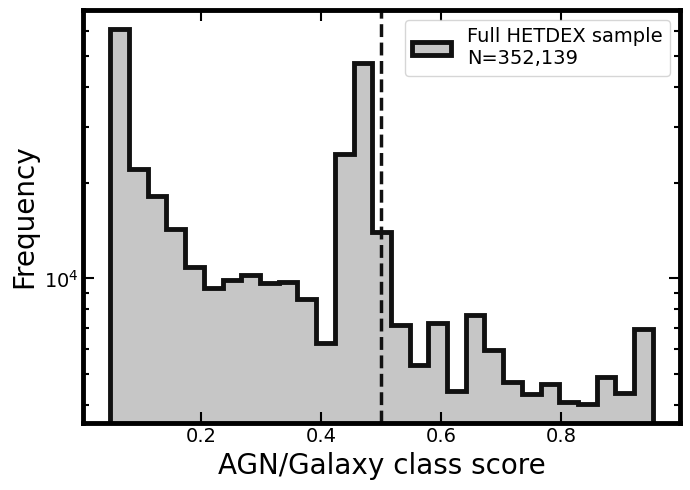

In [65]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(np.isfinite(full_catalog_df.loc[:, 'Score_AGN']))

ax1.hist(full_catalog_df.loc[:, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Full {used_area} sample\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_AGN_scores_{used_area}.pdf', bbox_inches='tight')
plt.show()

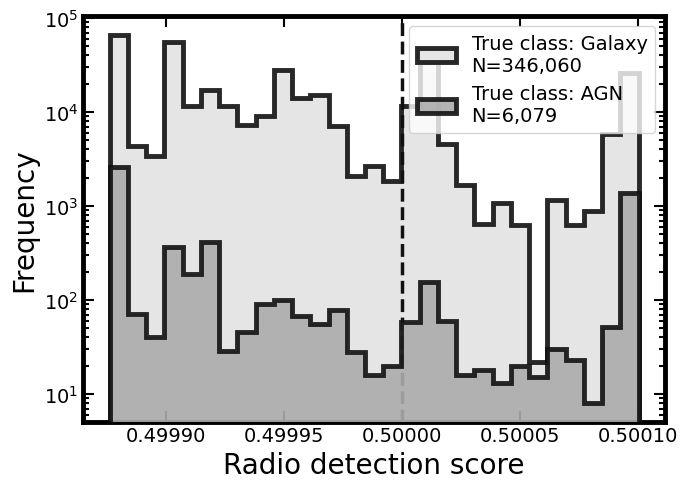

In [66]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_true_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

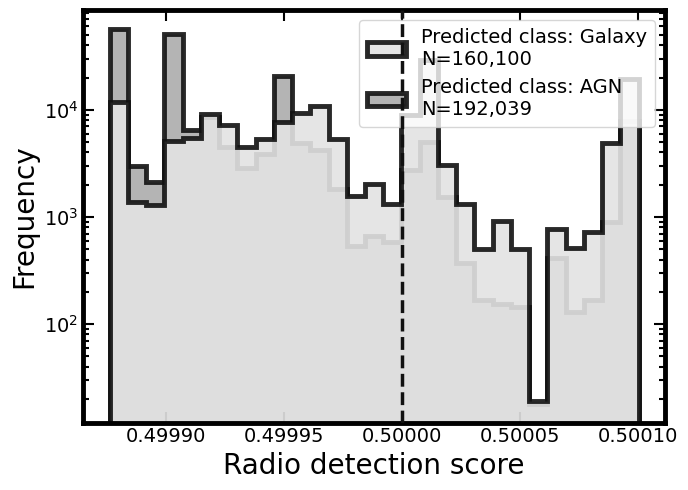

In [67]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=9)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_predicted_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

Plot histograms for predicted and original redshifts.

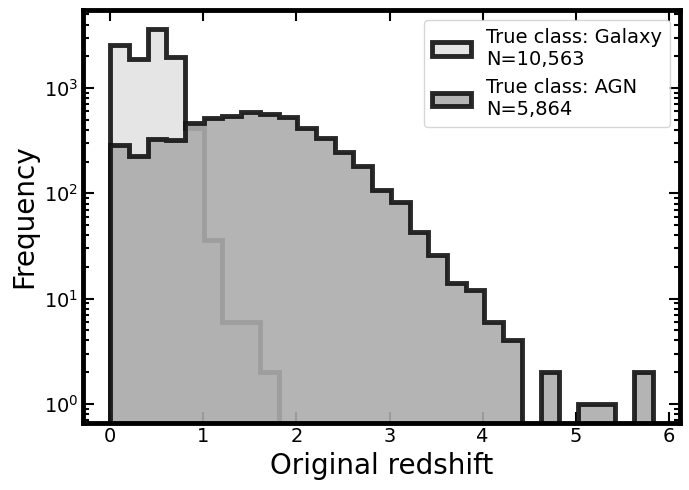

In [68]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_original_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

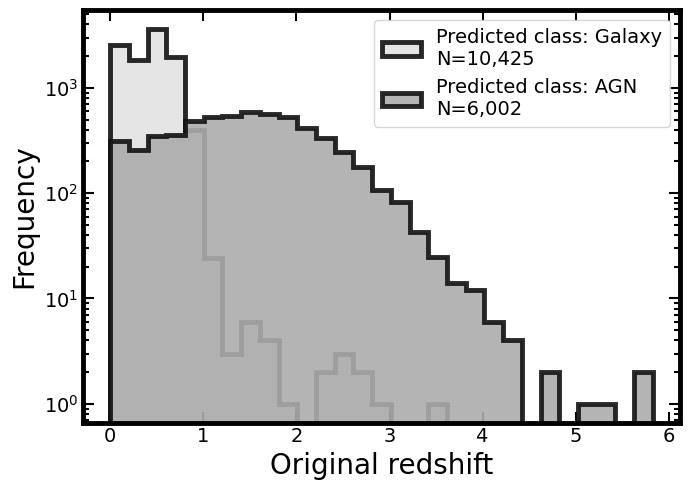

In [69]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <  threshold_AGN), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_true_redshift_predicted_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

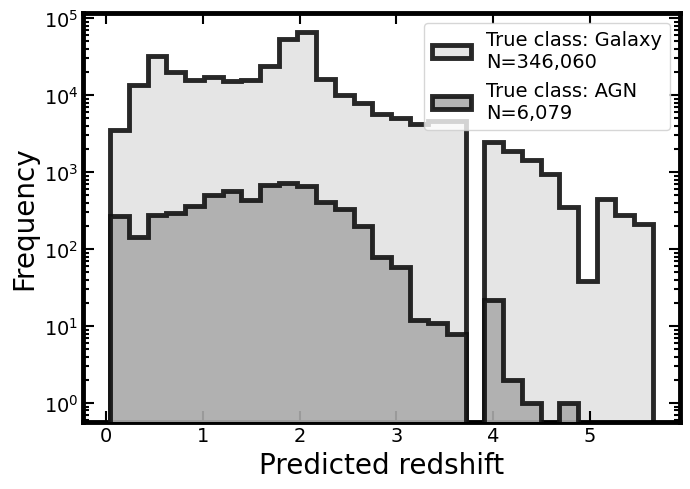

In [70]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

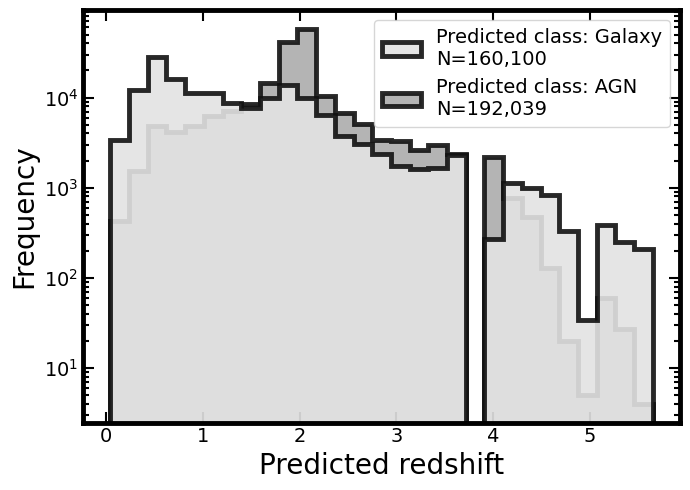

In [71]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'pred_Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'pred_Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'pred_Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'pred_Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_redshift_predicted_class_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Select sources predicted to be Radio AGN

In [72]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
full_catalog_df.loc[filter_radio_AGN_p, displayed_cols].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,22523.000000,22523.0,22523.000000,22523.0,1905.000000,22523.000000
mean,0.084758,1.0,0.329352,1.0,1.187663,1.370081
std,0.278527,0.0,0.469988,0.0,0.866530,0.760439
min,0.000000,1.0,0.000000,1.0,-0.000110,0.040300
25%,0.000000,1.0,0.000000,1.0,0.453000,0.775900
50%,0.000000,1.0,0.000000,1.0,1.075000,1.243700
75%,0.000000,1.0,1.000000,1.0,1.798000,1.898400
max,1.000000,1.0,1.000000,1.0,5.800000,5.182700


Add individual metrics for redshift

In [73]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [74]:
str_0_t    = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_t    = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t    = f'{num_str_t:,} are listed as SDSS-DR16 stars and {num_AGN_t:,} are MQC AGN.\n'
str_3_t    = f'Also, {num_radio_AGN_t:,} AGN are detected in radio.'

str_0_p    = f'Out of {num_radio_AGN_t:,} initial radio-detected AGN in {used_area},\n'
str_1_p    = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_p    = f'{num_AGN_p:,} are predicted to be AGN. From the predicted AGN,\n'
str_3_p    = f'{num_radio_AGN_p:,} are predicted to be detected in radio.'

str_0_rAGN = f'{num_radio_AGN_p:,} sources were predicted to be Radio AGN in {used_area}.\n'
str_1_rAGN = f'{num_rAGN_MQC_p:,} of them were listed in MQC.\n'
str_2_rAGN = f'{num_rAGN_gal_p:,} of them are listed as SDSS-DR16 galaxies.\n'
str_3_rAGN = f'{num_rAGN_str_p:,} of them are listed as SDSS-DR16 stars.\n'
str_4_rAGN = f'{num_rAGN_rad_p:,} of them have radio detections.\n'
str_5_rAGN = f'Thus, {num_new_rAGN_p:,} sources are new radio AGN.'

In [75]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)
print(str_0_p + str_1_p + str_2_p + str_3_p)
print('-' * 60)
print(str_0_rAGN + str_1_rAGN + str_2_rAGN + str_3_rAGN + str_4_rAGN + str_5_rAGN)
print('-' * 60)

------------------------------------------------------------
Out of 352,139 initial sources in HETDEX,
346,060 are confirmed to be galaxies. On the other side,
68 are listed as SDSS-DR16 stars and 6,079 are MQC AGN.
Also, 2,038 AGN are detected in radio.
------------------------------------------------------------
Out of 2,038 initial radio-detected AGN in HETDEX,
160,100 are predicted to be galaxies. On the other side,
192,039 are predicted to be AGN. From the predicted AGN,
22,523 are predicted to be detected in radio.
------------------------------------------------------------
22,523 sources were predicted to be Radio AGN in HETDEX.
1,909 of them were listed in MQC.
20,614 of them are listed as SDSS-DR16 galaxies.
7 of them are listed as SDSS-DR16 stars.
7,418 of them have radio detections.
Thus, 20,485 sources are new radio AGN.
------------------------------------------------------------


In [76]:
cols_4_table = show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN',\
                               'radio_detect', 'pred_radio', 'scaled_score_radio', 'scaled_score_rAGN', 'Z', 'pred_Z']

In [77]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = cols_4_table + cols_4_exp_all[used_area] + cols_photo

In [78]:
filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= 3.7

In [79]:
display(full_catalog_df.loc[filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['pred_Z'], ascending=False).head(25))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
2693993,J105449.48+483611.5,163.706161,48.603210,,10,0.0,1,0.371760,0,1,0.561552,0.208763,NaN,5.1827
6328478,J132420.48+502450.5,201.085342,50.414028,,10,0.0,1,0.475414,0,1,0.566459,0.269302,NaN,5.1619
2688931,J132245.76+524959.6,200.690689,52.833225,,10,0.0,1,0.478662,0,1,0.437556,0.209441,NaN,5.1572
925218,J135733.90+481557.2,209.391220,48.265907,,7,0.0,1,0.384805,0,1,0.598127,0.230162,-0.00011,5.0677
4273520,J120435.63+504657.1,181.148483,50.782516,,5,0.0,1,0.358862,0,1,0.506690,0.181832,NaN,4.7296
3390070,J150001.88+522257.0,225.007843,52.382500,,10,0.0,1,0.319478,0,1,0.561552,0.179404,NaN,4.6838
2919244,J123956.46+551951.4,189.985260,55.330967,,9,0.0,1,0.356559,0,1,0.442908,0.157923,NaN,4.6672
2943194,J122605.89+501443.9,186.524582,50.245518,,9,0.0,1,0.415118,0,1,0.605709,0.251441,NaN,4.6485
6154084,J145222.17+545516.9,223.092392,54.921368,,9,0.0,1,0.431523,0,1,0.449599,0.194012,NaN,4.6290
2037615,J113250.54+470330.0,173.210571,47.058346,,9,0.0,1,0.479934,0,1,0.463426,0.222414,NaN,4.5626


In [80]:
display(full_catalog_df.loc[filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
2693993,J105449.48+483611.5,163.706161,48.603210,,10,0.0,1,0.371760,0,1,0.561552,0.208763,NaN,5.1827
6328478,J132420.48+502450.5,201.085342,50.414028,,10,0.0,1,0.475414,0,1,0.566459,0.269302,NaN,5.1619
2688931,J132245.76+524959.6,200.690689,52.833225,,10,0.0,1,0.478662,0,1,0.437556,0.209441,NaN,5.1572
925218,J135733.90+481557.2,209.391220,48.265907,,7,0.0,1,0.384805,0,1,0.598127,0.230162,-0.00011,5.0677
4273520,J120435.63+504657.1,181.148483,50.782516,,5,0.0,1,0.358862,0,1,0.506690,0.181832,NaN,4.7296
3390070,J150001.88+522257.0,225.007843,52.382500,,10,0.0,1,0.319478,0,1,0.561552,0.179404,NaN,4.6838
2919244,J123956.46+551951.4,189.985260,55.330967,,9,0.0,1,0.356559,0,1,0.442908,0.157923,NaN,4.6672
2943194,J122605.89+501443.9,186.524582,50.245518,,9,0.0,1,0.415118,0,1,0.605709,0.251441,NaN,4.6485
6154084,J145222.17+545516.9,223.092392,54.921368,,9,0.0,1,0.431523,0,1,0.449599,0.194012,NaN,4.6290
2037615,J113250.54+470330.0,173.210571,47.058346,,9,0.0,1,0.479934,0,1,0.463426,0.222414,NaN,4.5626


In [81]:
display(full_catalog_df.loc[~filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['Score_AGN', 'pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
4846431,J131536.58+485629.1,198.902420,48.941429,QR,11,1.0,1,0.937819,1,1,0.982159,0.921087,3.612,3.9476
4857795,J111034.69+480037.1,167.644547,48.010307,Q,11,1.0,1,0.934556,0,0,0.123996,0.115882,3.935,3.9499
4883968,J143832.30+481815.4,219.634567,48.304298,Q,11,1.0,1,0.924758,0,0,0.168153,0.155501,3.838,3.9476
4836334,J134515.76+514242.3,206.315628,51.711754,Q,11,1.0,1,0.923174,1,1,0.982159,0.906704,3.632,3.9476
4828228,J112126.53+464239.9,170.360550,46.711098,Q,11,1.0,1,0.922938,0,0,0.200268,0.184835,3.603,3.9476
5442941,J133315.47+561039.1,203.314484,56.177525,,10,0.0,1,0.916653,0,0,0.028992,0.026576,NaN,3.9483
6462493,J131914.21+520200.0,199.809189,52.033337,QX,14,1.0,1,0.912135,1,1,0.603479,0.550455,3.910,3.9492
517011,J120214.91+475400.7,180.562088,47.900188,,10,0.0,1,0.905748,0,0,0.000000,0.000000,NaN,3.9483
4844445,J134128.42+471944.8,205.368423,47.329128,Q,7,1.0,1,0.905629,0,0,0.194469,0.176117,3.695,3.9483
6181967,J114751.85+501056.6,176.966049,50.182419,,10,0.0,1,0.896568,0,0,0.032114,0.028793,NaN,3.9483


In [82]:
display(full_catalog_df.loc[filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['scaled_score_radio', 'pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
4777641,J115926.29+494724.9,179.859512,49.790253,,5,0.0,1,0.321864,0,1,0.978591,0.314973,NaN,4.3771
4408175,J140430.32+554701.5,211.126343,55.783752,,9,0.0,1,0.396047,0,1,0.723015,0.286348,NaN,4.1123
5424307,J121440.01+562141.9,183.666702,56.361645,,9,0.0,1,0.401928,0,1,0.643622,0.258690,NaN,4.2659
6209521,J132429.00+492502.3,201.120850,49.417309,,9,0.0,1,0.318131,0,1,0.643622,0.204756,NaN,4.1630
2148849,J134244.22+563139.9,205.684235,56.527760,,9,0.0,1,0.372376,0,1,0.643622,0.239670,NaN,4.1612
4796842,J121254.72+531015.2,183.227982,53.170898,,9,0.0,1,0.404561,0,1,0.643622,0.260384,NaN,4.1577
4660577,J135158.23+553546.4,207.992615,55.596245,,9,0.0,1,0.421542,0,1,0.643622,0.271314,NaN,4.1555
5344480,J122235.64+551915.7,185.648529,55.321030,,9,0.0,1,0.395647,0,1,0.643622,0.254647,NaN,4.1542
4166212,J135941.42+551630.5,209.922592,55.275143,,9,0.0,1,0.358409,0,1,0.643622,0.230680,NaN,4.1116
4695746,J140100.68+534618.5,210.252823,53.771797,,9,0.0,1,0.422970,0,1,0.643622,0.272233,NaN,4.1113


In [83]:
display(full_catalog_df.loc[filt_new_rAGN_p * filter_high_z, cols_4_table].sort_values(by=['scaled_score_rAGN', 'pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
6338787,J145439.57+470741.9,223.664886,47.128338,,11,0.0,1,0.899541,0,1,0.599465,0.539243,NaN,3.9476
5081683,J143034.63+461135.1,217.644302,46.193085,,11,0.0,1,0.787798,0,1,0.579839,0.456796,NaN,3.9533
6703452,J114507.43+523926.1,176.280945,52.657242,,10,0.0,1,0.671410,0,1,0.593220,0.398294,NaN,3.9502
6386282,J145559.41+482013.0,223.997559,48.336948,,9,0.0,1,0.582851,0,1,0.642284,0.374356,NaN,3.9585
4456097,J122755.33+534435.5,186.980560,53.743206,,9,0.0,1,0.627278,0,1,0.592328,0.371555,NaN,3.9656
5113415,J121251.43+553451.6,183.214279,55.581013,,9,0.0,1,0.578618,0,1,0.592774,0.342990,NaN,3.9520
4659062,J120151.90+522204.8,180.466263,52.368000,,9,0.0,1,0.576901,0,1,0.588760,0.339656,NaN,4.5476
4876165,J145329.04+482206.0,223.371002,48.368351,Q,11,1.0,1,0.677400,0,1,0.491079,0.332657,3.445,3.9755
1219164,J125055.55+541641.9,192.731430,54.278309,,10,0.0,1,0.545511,0,1,0.599465,0.327015,NaN,4.3976
5742283,J133534.91+505129.6,203.895477,50.858227,,9,0.0,1,0.506723,0,1,0.637823,0.323200,NaN,3.9540


In [84]:
display(full_catalog_df.loc[filter_high_z, cols_4_table].sort_values(by=['scaled_score_rAGN', 'pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,radio_detect,pred_radio,scaled_score_radio,scaled_score_rAGN,Z,pred_Z
4846431,J131536.58+485629.1,198.902420,48.941429,QR,11,1.0,1,0.937819,1,1,0.982159,0.921087,3.612,3.9476
4836334,J134515.76+514242.3,206.315628,51.711754,Q,11,1.0,1,0.923174,1,1,0.982159,0.906704,3.632,3.9476
4880210,J135230.51+531108.5,208.127121,53.185715,Q,11,1.0,1,0.892433,1,1,0.982159,0.876511,4.223,3.9508
3992021,J145232.93+495329.8,223.137207,49.891617,Q,11,1.0,1,0.793569,1,1,0.993756,0.788613,3.885,3.9534
4824771,J122732.41+471045.1,186.885040,47.179184,Q,11,1.0,1,0.592463,1,1,0.981713,0.581628,3.829,3.9489
6462493,J131914.21+520200.0,199.809189,52.033337,QX,14,1.0,1,0.912135,1,1,0.603479,0.550455,3.910,3.9492
6338787,J145439.57+470741.9,223.664886,47.128338,,11,0.0,1,0.899541,0,1,0.599465,0.539243,NaN,3.9476
5081683,J143034.63+461135.1,217.644302,46.193085,,11,0.0,1,0.787798,0,1,0.579839,0.456796,NaN,3.9533
127301,J121336.14+540438.2,183.400604,54.077301,R,9,1.0,1,0.454433,1,1,0.981713,0.446123,NaN,4.1156
6703452,J114507.43+523926.1,176.280945,52.657242,,10,0.0,1,0.671410,0,1,0.593220,0.398294,NaN,3.9502


Confusion matrix for AGN/galaxy prediction on all sources

In [85]:
cm_AGN

array([[160014, 186046],
       [    86,   5993]])

In [86]:
cm_AGN.flatten()

array([160014, 186046,     86,   5993])

In [87]:
(30_044 + 931_022) * (30_044 + 351) * (799_274 + 931_022) * (799_274 + 351)

40416818919331494730000

In [88]:
np.sqrt(float((30_044 + 931_022) * (30_044 + 351) * (799_274 + 931_022) * (799_274 + 351)))

201039346694.45056

In [89]:
MCC_test = ((30044 * 799274) - (931022 * 351)) / np.sqrt(float((30044 + 931022) * (30044 + 351) * (799274 + 931022) * (799274 + 351)))

In [90]:
MCC_test

0.11782071382275258

In [91]:
MCC_AGN              = MCC_from_CM(cm_AGN)
ACC_AGN              = ACC_from_CM(cm_AGN)
F1_AGN               = F1_from_CM(cm_AGN)
Recall_AGN           = Recall_from_CM(cm_AGN)

Confusion matrices for AGN criteria from literature

In [92]:
MCC_AGN_S12          = MCC_from_CM(cm_AGN_S12)
ACC_AGN_S12          = ACC_from_CM(cm_AGN_S12)
F1_AGN_S12           = F1_from_CM(cm_AGN_S12)
Recall_AGN_S12       = Recall_from_CM(cm_AGN_S12)

MCC_AGN_M12          = MCC_from_CM(cm_AGN_M12)
ACC_AGN_M12          = ACC_from_CM(cm_AGN_M12)
F1_AGN_M12           = F1_from_CM(cm_AGN_M12)
Recall_AGN_M12       = Recall_from_CM(cm_AGN_M12)

MCC_AGN_M16          = MCC_from_CM(cm_AGN_M16)
ACC_AGN_M16          = ACC_from_CM(cm_AGN_M16)
F1_AGN_M16           = F1_from_CM(cm_AGN_M16)
Recall_AGN_M16       = Recall_from_CM(cm_AGN_M16)

MCC_AGN_B18          = MCC_from_CM(cm_AGN_B18)
ACC_AGN_B18          = ACC_from_CM(cm_AGN_B18)
F1_AGN_B18           = F1_from_CM(cm_AGN_B18)
Recall_AGN_B18       = Recall_from_CM(cm_AGN_B18)

Confusion matrix for radio detection prediction on all predicted AGN

In [93]:
MCC_radio            = MCC_from_CM(cm_radio)
ACC_radio            = ACC_from_CM(cm_radio)
F1_radio             = F1_from_CM(cm_radio)
Recall_radio         = Recall_from_CM(cm_radio)

Confusion matrix for radio detection prediction on all confirmed sources

In [94]:
MCC_radio_conf       = MCC_from_CM(cm_radio_conf)
ACC_radio_conf       = ACC_from_CM(cm_radio_conf)
F1_radio_conf        = F1_from_CM(cm_radio_conf)
Recall_radio_conf    = Recall_from_CM(cm_radio_conf)

Confusion matrix for radio AGN detection prediction.

In [95]:
MCC_radio_AGN        = MCC_from_CM(cm_radio_AGN)
ACC_radio_AGN        = ACC_from_CM(cm_radio_AGN)
F1_radio_AGN         = F1_from_CM(cm_radio_AGN)
Recall_radio_AGN     = Recall_from_CM(cm_radio_AGN)

Confusion matrix for radio AGN detection prediction on confirmed sources.

In [96]:
MCC_radio_AGN_conf    = MCC_from_CM(cm_radio_AGN_conf)
ACC_radio_AGN_conf    = ACC_from_CM(cm_radio_AGN_conf)
F1_radio_AGN_conf     = F1_from_CM(cm_radio_AGN_conf)
Recall_radio_AGN_conf = Recall_from_CM(cm_radio_AGN_conf)

Print metrics

In [97]:
print('Metrics for AGN prediction on all spectroscopically confirmed sources.')
print(f'Sample size,                        N = {np.sum(filter_gal_AGN_t):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_AGN:.4f}')

Metrics for AGN prediction on all spectroscopically confirmed sources.
Sample size,                        N = 352,139
Matthews Correlation Coefficient, MCC = 0.1173
Accuracy,                         ACC = 0.4714
F-1 Score,                         F1 = 0.0605
Recall,                        Recall = 0.9859


In [98]:
print('Metrics for AGN detection criteria (from literature) on all spectroscopically confirmed sources.')
print(f'Sample size, N = {np.sum(filter_gal_AGN_t):,}')
print('Criterion:        S12\tM12\tM16\tMB18')
print(f'MCC,       MCC = {MCC_AGN_S12:.4f}\t{MCC_AGN_M12:.4f}\t{MCC_AGN_M16:.4f}\t{MCC_AGN_B18:.4f}')
print(f'Accuracy,  ACC = {ACC_AGN_S12:.4f}\t{ACC_AGN_M12:.4f}\t{ACC_AGN_M16:.4f}\t{ACC_AGN_B18:.4f}')
print(f'F-1 Score,  F1 = {F1_AGN_S12:.4f}\t{F1_AGN_M12:.4f}\t{F1_AGN_M16:.4f}\t{F1_AGN_B18:.4f}')
print(f'Recall, Recall = {Recall_AGN_S12:.4f}\t{Recall_AGN_M12:.4f}\t{Recall_AGN_M16:.4f}\t{Recall_AGN_B18:.4f}')

Metrics for AGN detection criteria (from literature) on all spectroscopically confirmed sources.
Sample size, N = 352,139
Criterion:        S12	M12	M16	MB18
MCC,       MCC = 0.0687	0.5169	0.4262	0.4375
Accuracy,  ACC = 0.5144	0.9869	0.9755	0.9654
F-1 Score,  F1 = 0.0509	0.4902	0.4296	0.4112
Recall, Recall = 0.7536	0.3644	0.5343	0.6998


In [99]:
print('Metrics for radio detection prediction on all predicted AGN')
print(f'Sample size,                        N = {np.sum(filter_AGN_p):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio:.4f}')
print(f'Recall,                        Recall = {Recall_radio:.4f}')

Metrics for radio detection prediction on all predicted AGN
Sample size,                        N = 192,039
Matthews Correlation Coefficient, MCC = 0.4154
Accuracy,                         ACC = 0.9004
F-1 Score,                         F1 = 0.4368
Recall,                        Recall = 0.6484


In [100]:
print('Metrics for radio detection prediction on all confirmed sources predicted to be AGN')
print(f'Sample size,                        N = {np.sum(filter_AGN_p & filter_gal_AGN_t):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_conf:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_conf:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_conf:.4f}')
print(f'Recall,                        Recall = {Recall_radio_conf:.4f}')

Metrics for radio detection prediction on all confirmed sources predicted to be AGN
Sample size,                        N = 192,039
Matthews Correlation Coefficient, MCC = 0.4154
Accuracy,                         ACC = 0.9004
F-1 Score,                         F1 = 0.4368
Recall,                        Recall = 0.6484


In [101]:
print('Metrics for radio AGN detection prediction')
print(f'Sample size,                        N = {total_size:,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_radio_AGN:.4f}')

Metrics for radio AGN detection prediction
Sample size,                        N = 352,139
Matthews Correlation Coefficient, MCC = 0.2556
Accuracy,                         ACC = 0.9405
F-1 Score,                         F1 = 0.1467
Recall,                        Recall = 0.8837


In [102]:
print('Metrics for radio AGN detection prediction on all confirmed sources')
print(f'Sample size,                        N = {np.sum(filter_gal_AGN_t):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_AGN_conf:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_AGN_conf:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_AGN_conf:.4f}')
print(f'Recall,                        Recall = {Recall_radio_AGN_conf:.4f}')

Metrics for radio AGN detection prediction on all confirmed sources
Sample size,                        N = 352,139
Matthews Correlation Coefficient, MCC = 0.2556
Accuracy,                         ACC = 0.9405
F-1 Score,                         F1 = 0.1467
Recall,                        Recall = 0.8837


In [103]:
print('Metrics for redshift prediction on all predicted radio AGN with only one Z model')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"])):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_early:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_early:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_early:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_early:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_early:.4f}')

Metrics for redshift prediction on all predicted radio AGN with only one Z model
Sample size,                        N = 16,427
Sigma MAD                       σ MAD = 0.0969
Sigma NMAD,                    σ NMAD = 0.0473
Sigma z,                          σ z = 0.0933
Sigma z normalized,             σ z N = 0.0532
Outlier fraction,                   η = 0.1118


In [104]:
print('Metrics for redshift prediction on all predicted radio AGN with all models')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"])):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_field:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_field:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_field:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_field:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_field:.4f}')

Metrics for redshift prediction on all predicted radio AGN with all models
Sample size,                        N = 16,427
Sigma MAD                       σ MAD = 0.0969
Sigma NMAD,                    σ NMAD = 0.0474
Sigma z,                          σ z = 0.0959
Sigma z normalized,             σ z N = 0.0575
Outlier fraction,                   η = 0.1118


In [105]:
print('Metrics for redshift prediction on predicted radio AGN with only one Z model at high z (original prediction)')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"]) & np.array(full_catalog_df.loc[:, "pred_Z"] >= redshift_lim_c)):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_early_hiz:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_early_hiz:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_early_hiz:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_early_hiz:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_early_hiz:.4f}')

Metrics for redshift prediction on predicted radio AGN with only one Z model at high z (original prediction)
Sample size,                        N = 58
Sigma MAD                       σ MAD = 0.2642
Sigma NMAD,                    σ NMAD = 0.0544
Sigma z,                          σ z = 0.2359
Sigma z normalized,             σ z N = 0.2332
Outlier fraction,                   η = 0.1250


In [106]:
print('Metrics for redshift prediction on predicted radio AGN with all models at high z')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"]) & np.array(full_catalog_df.loc[:, "pred_Z"] >= redshift_lim_c)):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_field_hiz:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_field_hiz:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_field_hiz:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_field_hiz:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_field_hiz:.4f}')

Metrics for redshift prediction on predicted radio AGN with all models at high z
Sample size,                        N = 58
Sigma MAD                       σ MAD = 0.4350
Sigma NMAD,                    σ NMAD = 0.0890
Sigma z,                          σ z = 0.3091
Sigma z normalized,             σ z N = 0.3058
Outlier fraction,                   η = 0.1250


Plot predictions

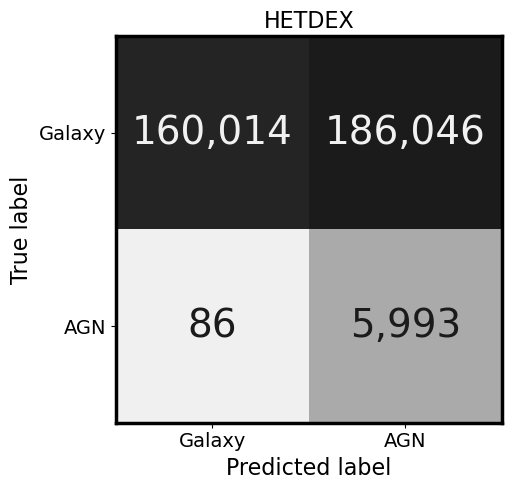

In [107]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

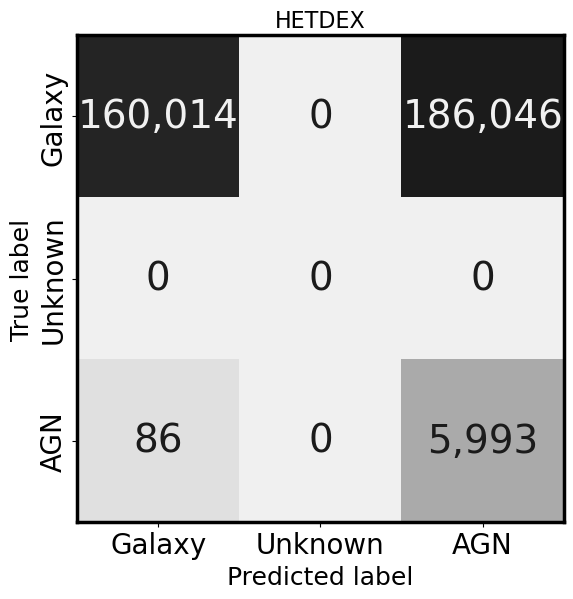

In [108]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN_large, title=used_area, axin=ax1, display_labels=['Galaxy', 'Unknown', 'AGN'], log_stretch=False)

ax1.xaxis.get_label().set_fontsize(18)
ax1.yaxis.get_label().set_fontsize(18)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='y', which='major', labelrotation=90)
plt.yticks(va='center')

if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_all_classes_{used_area}.pdf', bbox_inches='tight')
plt.show()

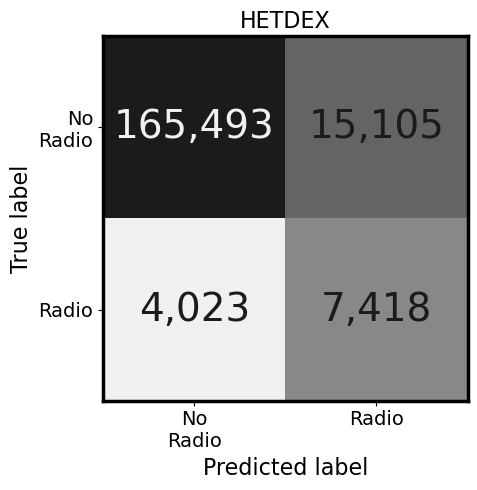

In [109]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

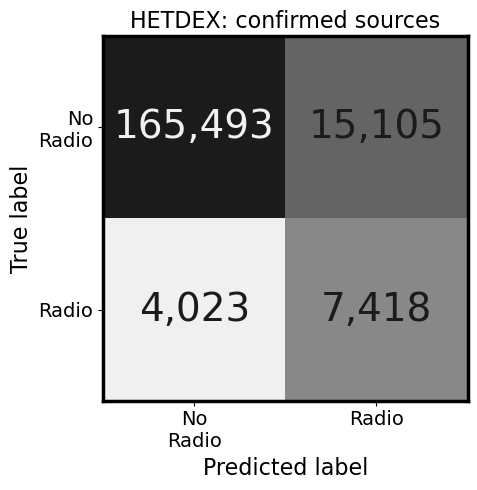

In [110]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_conf, title=used_area+': confirmed sources', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_confirmed_{used_area}.pdf', bbox_inches='tight')
plt.show()

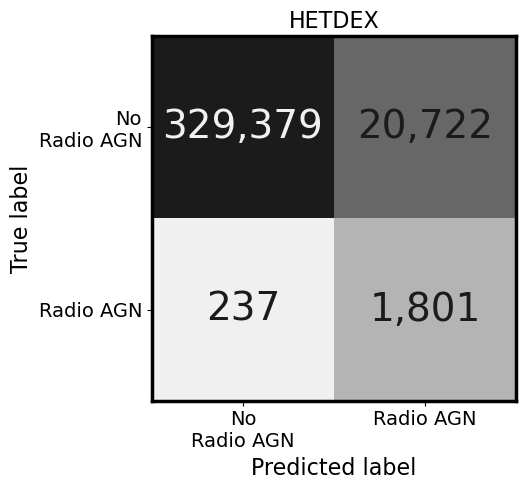

In [111]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_AGN, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

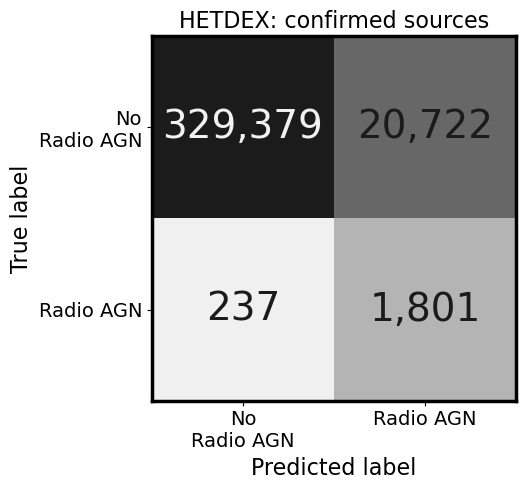

In [112]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_AGN_conf, title=used_area + ': confirmed sources', axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_AGN_confirmed_{used_area}.pdf', bbox_inches='tight')
plt.show()

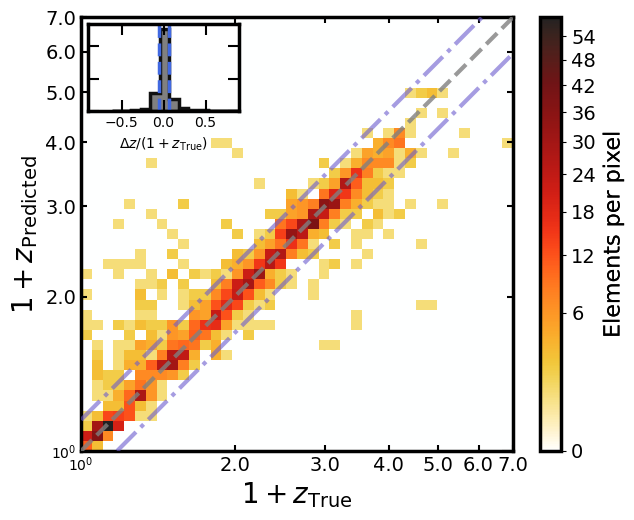

In [113]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(f'plots/compare_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

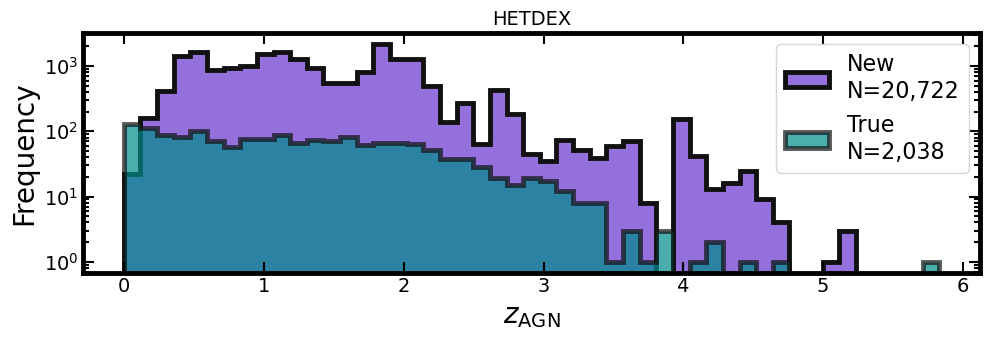

In [114]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(full_catalog_df.loc[:, 'Z']),\
                           np.nanmin(full_catalog_df.loc[:, 'pred_Z'])])
max_for_range = np.nanmax([np.nanmax(full_catalog_df.loc[:, 'Z']),\
                           np.nanmax(full_catalog_df.loc[:, 'pred_Z'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)



_, bins, _ = ax1.hist(full_catalog_df.loc[filt_new_rAGN_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"New\nN={np.sum(filt_new_rAGN_p):,}")
ax1.hist(full_catalog_df.loc[filter_radio_AGN_t * filter_radio_AGN_p, 'Z'], bins=bins_z, histtype='stepfilled', ec='k',\
         fc='darkcyan', lw=3.5, label=f"True\nN={np.sum(filter_radio_AGN_t):,}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_true_predicted_z_{used_area}.pdf')
plt.show()

---

## Additional test with data from Ananna et al., 2017

In [115]:
if compare_A17_flag:
    full_catalog_A17_df = pd.read_hdf(cat_path + file_S82_Ananna_17, key='df').drop(columns=features_2_discard)

In [116]:
if compare_A17_flag:
    full_catalog_A17_df = pyr.predict_model(redshift_reg, data=full_catalog_A17_df, round=8)
    full_catalog_A17_df = full_catalog_A17_df.rename(columns={'Label': 'pred_Z', 'is_AGN': 'class'})
    full_catalog_A17_df['pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    redshift_lim_0    = 2.0
    redshift_tol_0    = 0.0
    redshift_lim_1    = 3.0
    redshift_tol_1    = 0.0
    redshift_lim_2    = 3.7
    redshift_tol_2    = 0.0
    if use_second_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_2, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_0 + redshift_tol_0)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    if use_third_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_3, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_1 + redshift_tol_1)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    if use_fourth_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_4, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_2 + redshift_tol_2)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)

In [117]:
if compare_A17_flag:
    sigma_mad_AGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_AGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_AGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_AGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_AGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [118]:
if compare_A17_flag:
    print('Metrics for redshift prediction on AGN from Ananna et al., 2017')
    print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"])):,}')
    print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_AGN_A17:.4f}')
    print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_AGN_A17:.4f}')
    print(f'Sigma z,                          \u03C3 z = {sigma_z_AGN_A17:.4f}')
    print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_AGN_A17:.4f}')
    print(f'Outlier fraction,                   \u03B7 = {out_frac_AGN_A17:.4f}')

In [119]:
if compare_A17_flag:
    fig              = plt.figure(figsize=(7.5,4.3))
    ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
    
    min_score        = np.nanmin([np.nanmin(full_catalog_A17_df.loc[:, 'zsp']), np.nanmin(full_catalog_A17_df.loc[:, 'pred_Z'])])
    max_score        = np.nanmax([np.nanmax(full_catalog_A17_df.loc[:, 'zsp']), np.nanmax(full_catalog_A17_df.loc[:, 'pred_Z'])])
    score_bins       = np.linspace(min_score, max_score, 30)
    
    sample_size_orig = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']))
    sample_size_pred = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    
    ax1.hist(full_catalog_A17_df.loc[:, 'zsp'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
             label=f'Original\nN={sample_size_orig:,}', zorder=2)
    ax1.hist(full_catalog_A17_df.loc[:, 'pred_Z'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.7,\
             label=f'Predicted\nN={sample_size_pred:,}', zorder=1)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    ax1.set_title('S82: Ananna+17')
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/hist_redshift_AGN_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()

In [120]:
if compare_A17_flag:
    full_catalog_A17_df = full_catalog_A17_df.loc[np.array(full_catalog_A17_df.loc[:, 'class'] == 1) &\
                                                  np.array(full_catalog_A17_df.loc[:, 'radio_detect'] == 1)]

In [121]:
if compare_A17_flag:
    used_z_col = 'zsp'
    full_catalog_A17_df['Delta_z_N'] = np.around((full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                 (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)
    full_catalog_A17_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                  (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)

In [122]:
if compare_A17_flag:
    show_columns_A17 = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'class', 'radio_detect', 'Z', 'zsp', 'pred_Z', 'Delta_z_N']
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by='pred_Z', ascending=False).head(10))
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by=used_z_col, ascending=False).head(10))

In [123]:
if compare_A17_flag:
    sigma_mad_rAGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_rAGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_rAGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_rAGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_rAGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [124]:
if compare_A17_flag:
    print('Metrics for redshift prediction on radio AGN from Ananna et al., 2017')
    print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"])):,}')
    print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_rAGN_A17:.4f}')
    print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_rAGN_A17:.4f}')
    print(f'Sigma z,                          \u03C3 z = {sigma_z_rAGN_A17:.4f}')
    print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_rAGN_A17:.4f}')
    print(f'Outlier fraction,                   \u03B7 = {out_frac_rAGN_A17:.4f}')

In [125]:
if compare_A17_flag:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    plot_redshift_compare(full_catalog_A17_df.loc[:, used_z_col], full_catalog_A17_df.loc[:, 'pred_Z'],\
                          ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    if save_plot_flag:
        plt.savefig(f'plots/compare_redshift_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()